# Boosting

На примерах урока мы увидели, что алгоритм XGBoost работает лучше и быстрее относительно GradientBoosting и AdaBoost. Поэтому в этом домашнем задании предлагаем посмотреть, какие еще интересные методы существуют в библиотеке для реализацией этого алгоритма.

### Важность признаков

Признаки, которые используют для обучения модели, оказывают большое влияние на ее качество. Неинформативные или слабо информативные признаки могут существенно понизить эффективность модели.

Отбор признаков – процесс выбора признаков, имеющих наиболее тесные взаимосвязи с целевой переменной. Он позволяет:
- уменьшить переобучение: чем меньше избыточных данных, тем меньше возможностей для модели принимать решения на основе «шума»
- повысить точность: чем меньше противоречивых данных, тем выше точность
- сократить время обучения: чем меньше данных, тем быстрее обучается модель

В библиотеке sckit-learn есть раздел feature_selection, который помогает автоматизировать этот процесс на основе методов статистики, линейной алгебры и некоторых специальных алгоритмов, таких как уже знакомый нам PCA - метод главных компонент.

Некоторые из таких методов реализованы в библиотеках для конкретных алгоритмов, к которым относится и xgboost.

Сгенерируем синтетические данные.

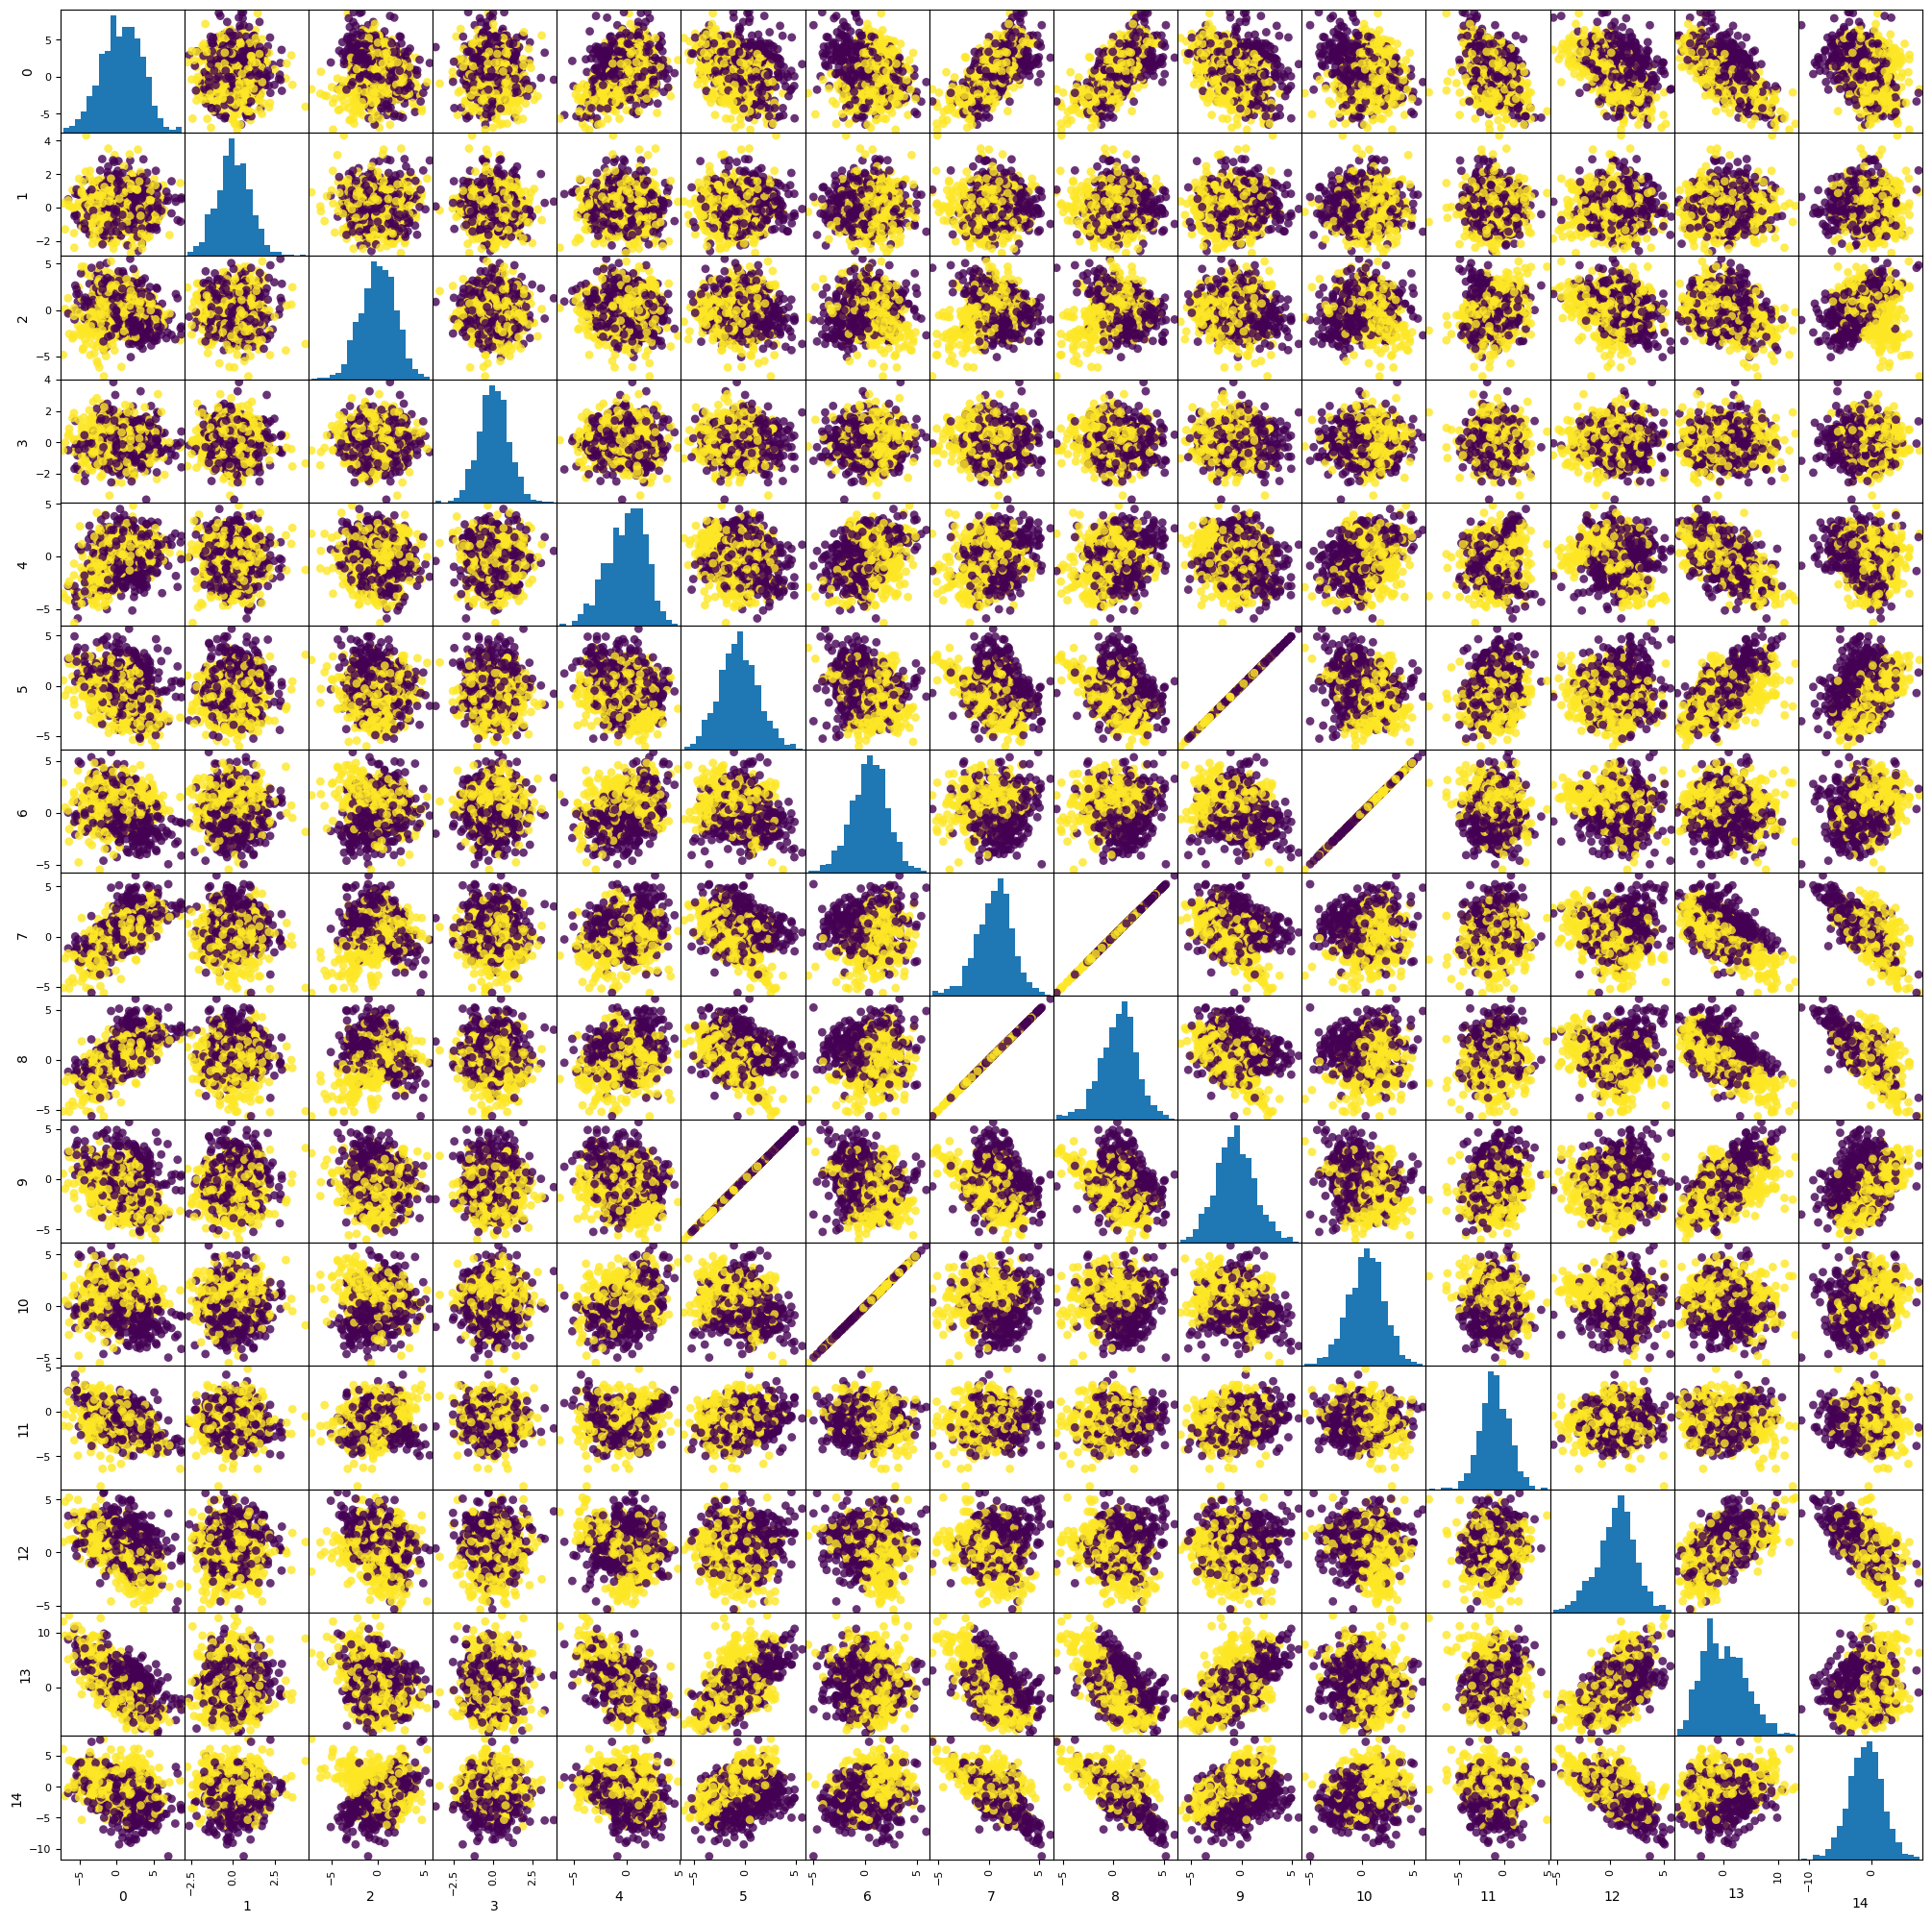

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd

x, y = make_classification(n_samples=1000, n_features=15, n_informative=7,
                           n_redundant=3, n_repeated=3, random_state=17)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y, random_state=17)

features = pd.DataFrame(x)
targets = pd.Series(y)

scat_mtrx = pd.plotting.scatter_matrix(features, c=targets, figsize=(25, 25), marker='o',
                                       hist_kwds={'bins': 20}, s=40, alpha=.8)

Теперь приступим к построению модели. В уроке мы разбирали алгоритм xgboost в интерфейсе библиотеки sklearn: для обучения использовали метод *fit* модели, а для предсказаний - *predict*.

Здесь будем использовать интерфейс библиотеки xgboost.

В этом интерфейсе для обучения XGBoost данные должны быть представлены в виде объекта DMatrix - внутренней структуры данных, используемой библиотекой  XGBoost, которая оптимизирована как по эффективности работы с памятью, так и по скорости обучения.

Также заранее определим параметры алгоритма:
- бинарная классификация - 'objective': 'binary:logistic'
- глубина деревьев - 'max_depth': 3
- шаг градиентного спуска (скорость обучения) - 'eta': 0.1
- количество итераций бустинга - num_rounds = 60

In [2]:
import xgboost as xgb

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

params = {'objective': 'binary:logistic',
          'max_depth': 3,
          'eta': 0.1}

num_rounds = 60

### 1.
С помощью метода *train* библиотеки xgboost обучите модель. Передайте в метод вышеопределенные словарь параметров, тренировочные данные в формате DMatrix и число итераций.

In [3]:
xgb_model = xgb.train(dtrain=dtrain, params=params, num_boost_round=num_rounds)

### 2.
В методе *train* есть параметр *evals* - список валидационных наборов данных, для которых будут оцениваться показатели во время обучения. Они помогут нам отслеживать качество модели для каждой итерации.

Создайте список из двух кортежей (dtest, 'test') и (dtrain, 'train'). Снова определите метод train аналогично предыдущему пункту, добавив этот список в качестве параметра.

In [4]:
evals = [(dtest, 'test'), (dtrain, 'train')]
xgb_model = xgb.train(dtrain=dtrain, params=params, num_boost_round=num_rounds, evals=evals)

[0]	test-logloss:0.66218	train-logloss:0.65393
[1]	test-logloss:0.63720	train-logloss:0.61917
[2]	test-logloss:0.61560	train-logloss:0.59160
[3]	test-logloss:0.59857	train-logloss:0.56560
[4]	test-logloss:0.57896	train-logloss:0.54453
[5]	test-logloss:0.56461	train-logloss:0.52541
[6]	test-logloss:0.55427	train-logloss:0.50501
[7]	test-logloss:0.54510	train-logloss:0.48785
[8]	test-logloss:0.53807	train-logloss:0.47188
[9]	test-logloss:0.52503	train-logloss:0.45870
[10]	test-logloss:0.51390	train-logloss:0.44352
[11]	test-logloss:0.50625	train-logloss:0.43231
[12]	test-logloss:0.49790	train-logloss:0.42220
[13]	test-logloss:0.48893	train-logloss:0.41076
[14]	test-logloss:0.47963	train-logloss:0.40002
[15]	test-logloss:0.47573	train-logloss:0.39206
[16]	test-logloss:0.46904	train-logloss:0.38432
[17]	test-logloss:0.46636	train-logloss:0.37817
[18]	test-logloss:0.46102	train-logloss:0.37129
[19]	test-logloss:0.45686	train-logloss:0.36514
[20]	test-logloss:0.45077	train-logloss:0.35970
[2

### 3.
В качестве метрики оценки важности признаков в XGBoost используется F-score, которая вычисляется на основе того, как часто делалось разбиение по данному признаку.

Используйте метод plot_importance библиотеки XGBoost. Передайте туда в качестве параметра xgb_model.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

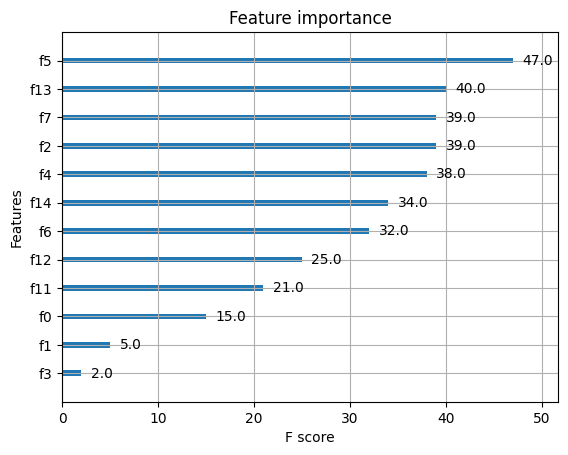

In [5]:
xgb.plot_importance(xgb_model)

По полученным данным можно посмотреть, какие признаки являются излишними и их можно убрать, а какие наиболее важны при обучении модели, т.е. используются чаще всего.

### Несбалансированные выборки

Мы уже упоминали о том, что работа с несбалансированными выборками несколько отличается от работы с идеальными датасетами. В XGBoost есть возможность несколько упростить эту работу:
- задать большие веса некоторым объектам при инициализации DMatrix
- контролировать соотношение числа объектов разных классов с помощью параметра set_pos_weight

Сгенерируем несбалансированную выборку.

In [6]:
x, y = make_classification(n_samples=1000, n_features=7, n_informative=3, n_redundant=3,
                           n_classes=2, weights=[.9, .1], random_state=20)

print(f'There are {sum(y)} positive instances')

There are 104 positive instances


### 4.
Разбейте выборку на тренировочную и тестовую, соблюдая стратификацию по *y* и размер тестового датасета 0.3. Создайте объекты DMatrix для тренировочной и тестовой выборок.

In [ ]:
from sklearn.model_selection import train_test_split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y, random_state=17)
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)


Зададим параметры для алгоритма и количество итераций.

In [8]:
params = {'objective': 'binary:logistic',
          'max_depth': 1,
          'silent': 1,
          'eta': 1}

num_rounds = 30

### 5.
С помощью метода train обучите модель. С помощью метода predict получите предсказания для тестовых данных. Так как алгоритм возвращает вероятности, получите бинарную матрицу значений этих вероятностей, элементы которой при полученной вероятности > 0.5 равны True, а при вероятности <= 0.5 равны False. Выведите эту матрицу.

In [10]:
xgb_model = xgb.train(dtrain=dtrain, params=params, num_boost_round=num_rounds)
predicts = xgb_model.predict(dtest)
predicts[:10]

/home/hik0/mount/500_gb/data_science/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [20:11:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


array([4.6124510e-02, 5.3334953e-03, 1.0922975e-01, 1.3120407e-01,
       4.2803013e-03, 7.5065631e-01, 4.2070034e-05, 1.5317744e-02,
       1.4829642e-02, 2.1073751e-03], dtype=float32)

In [19]:
predicts = list(map(lambda x: x>0.5, predicts))
predicts[:10]

[False, False, False, False, False, True, False, False, False, False]

### 6.
Выведите матрицу ошибок, точность и полноту для полученных предсказаний.

In [13]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [20]:
print(confusion_matrix(y_test, predicts))

[[264   5]
 [ 17  14]]


In [21]:
print(precision_score(y_test, predicts))

0.7368421052631579


In [22]:
print(recall_score(y_test, predicts))

0.45161290322580644


Видно, что полнота гораздо ниже точности, т.е. алгоритм плохо распознает объекты класса, который представлен меньшим количеством экземпляров.

Теперь зададим вручную веса для экземпляров классов.

In [23]:
import numpy as np

weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 5

### 7.
Повторите то же, что делали ранее: создайте объекты DMatrix - для тренировочных данных укажите веса, а для тестовых оставьте только сами данные; обучите модель и получите ее предсказания так же, как и в предыдущем случае. Выведите матрицу ошибок, точность и полноту.

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y, random_state=17)
dtrain = xgb.DMatrix(x_train, y_train, weight=weights)
dtest = xgb.DMatrix(x_test, y_test)

In [25]:
xgb_model = xgb.train(dtrain=dtrain, params=params, num_boost_round=num_rounds)
predicts = xgb_model.predict(dtest)
predicts = list(map(lambda x: x>0.5, predicts))
print(confusion_matrix(y_test, predicts))
print(precision_score(y_test, predicts))
print(recall_score(y_test, predicts))

[[252  17]
 [  8  23]]
0.575
0.7419354838709677


/home/hik0/mount/500_gb/data_science/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [20:20:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Можем увидеть, что значение полноты увеличилось, но при этом точность уменьшилась. Если нам важны обе метрики, то пригодится параметр scale_pos_weight в XGBoost.

### 8.
Снова создайте объекты DMatrix, как в первом случае (без задания весов).

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y, random_state=17)
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

### 9.
Инициализируйте параметр scale_pos_weight как соотношение числа объектов двух классов. Для этого число объектов класса 0 разделите на число объектов класса 1. Добавьте в словарь параметров алгоритма params пару с ключом 'scale_pos_weight' и значением, равным полученному соотношению классов.

In [36]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'silent': 1,
    'eta': 1,
    'scale_pos_weight': scale_pos_weight
}

### 10.
Обучите модель с параметрами params и получите ее предсказания для тестовой выборки. Выведите матрицу ошибок, точность и полноту.**

In [37]:
xgb_model = xgb.train(dtrain=dtrain, params=params, num_boost_round=num_rounds)
predicts = xgb_model.predict(dtest)
predicts = list(map(lambda x: x>0.5, predicts))
print(confusion_matrix(y_test, predicts))
print(precision_score(y_test, predicts))
print(recall_score(y_test, predicts))

[[240  29]
 [  6  25]]
0.46296296296296297
0.8064516129032258


/home/hik0/mount/500_gb/data_science/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [20:24:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Значение параметра scale_pos_weight надо выбирать в зависимости от желаемого соотношения между точностью и полнотой. Например, если нам нужны примерно одинаковые значения precision и recall, в данном случае следует уменьшить полученное значение параметра в несколько раз.